In [1]:
#!pip install gym
#!pip install tensorflow[and-cuda]
#!pip install pygame

In [2]:
# set tf warning level to 2 ....shows errors but not warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.__version__

In [3]:
from gym import Env
from gym.spaces import MultiBinary, Discrete, Box

import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
#tf.config.run_functions_eagerly(True)
#print(tf.config.functions_run_eagerly())
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers, models
# for experience replay
from collections import deque
from tensorflow.keras.layers import Dense, Flatten

# tyr legacy adam due to numpy error
from tensorflow.keras.optimizers import Adam


import numpy as np
import random
import os

import pygame


# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns, performFourierAndLimitHarmonics, scaler_sec_midnight, save_component, load_component, calculate_phase_and_time_difference

# Set the random seed
seed_value = 44
np.random.seed(seed_value)
random.seed(seed_value)

In [4]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1727549604.577152  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727549604.609000  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727549604.611667  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Create Environment

In [5]:
# ubuntu
df_normalised = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_12_23_sec_minmax.csv", index_col='time_in_seconds')
data_array = df_normalised.to_numpy()
#df_normalised.shape

In [6]:
#df_normalised

In [7]:
data_array[35].max()

1.0

In [8]:
component_pos = {key: idx for idx, key in enumerate(df_normalised.columns)}
#component_pos.items()

In [9]:
#data_array[component_pos['LIT101']]

In [10]:
#df_comp_files

In [11]:
path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/'
df_comp_files = pd.read_csv(path + 'component_filenames.csv', index_col=0)
components = {}
for component_name, filename in df_comp_files['filename'].items():    
    # put returned component object into dict
    components[component_name] = load_component(filename)
    #print(filename)

Component 'FIT101' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/FIT101.
Component 'LIT101' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/LIT101.
Component 'MV101' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/MV101.
Component 'P101' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/P101.
Component 'P102' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/P102.
Component 'AIT201' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/AIT201.
Component 'AIT202' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/AIT202.
Component 'AIT203' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/AIT203.
Component 'FIT201' has been loaded from /home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/F

In [12]:
#components['LIT101'].norm_step_size

In [13]:
# test lstm swat simulator
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')

swat_lstm = tf.keras.models.load_model('best_model_20.keras')
model_window = 20

#swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
#model_window = 100



I0000 00:00:1727549605.413839  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727549605.416819  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727549605.419816  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727549605.531757  114092 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

prediction = swat_lstm.predict(reshaped_input)

# Q Learning Table Implementation

In [14]:
data_array.shape

(86400, 37)

In [87]:
class SwatEnv(Env):
    def __init__(self, data_array, window_size=19, episode_length=100):
        print('init reached')
        
        # Define the action space as a combination of 6 binary values (on/off states)
        self.action_space = MultiBinary(6)  # Represents 6 binary actions: MV101, MV201, MV301, MV302, MV303, MV304
        
        # Define observation space (shape and limits can be adjusted as needed)
        if len(data_array.shape) == 2:
            # Add a batch dimension to make it (1, time_steps, features)
            data_array = data_array[np.newaxis, :, :]
        self.observation_space = Box(
            low=np.round(np.full((1, 37), 0.00), 2),  # 1x37 array with all elements set to 0.00
            high=np.round(np.full((1, 37), 100.00), 2),  # 1x37 array with all elements set to 100.00
            dtype=np.float32  # Specify float with two decimal places precision
        )
        
        # Initialize data parameters
        self.data_array = data_array
        self.window_size = window_size
        self.episode_length = episode_length

        # Use reset_env to initialize the data window to use
        self.reset_env()      

        # Initialize other variables
        self.lit_value_record = {'LIT101': [], 'LIT301': [], 'LIT401': []}

    def sample_observation(self):
        # Return a random observation
        return np.round(self.observation_space.sample(), 2)

    def update_state(self, state_history, action_input):
        # Ensure action_input is reshaped to 1x37 array
        action_input = action_input.reshape(1, -1)

        # Add action to previous states
        model_input = np.concatenate((state_history[:, 1:, :], action_input[:, np.newaxis, :]), axis=1)
        
        # Predict the new state using the LSTM model (replace `swat_lstm` with your model)
        new_state = swat_lstm.predict(model_input)
        new_state = np.round(new_state, 2)
        
        # Flatten new_state from (1,37) to (37,)
        new_state = new_state.flatten()
        
        return new_state

    def step(self, action):
        # Copy the current state
        action_input = self.state.copy()
    
        # Update the states of MV101, MV201, MV301, MV302, MV303, MV304 based on the binary action values
        component_mapping = ['MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304']
        for i, component in enumerate(component_mapping):
            action_input[component_pos[component]] = action[i]
    
        # Get the new state using the updated action_input
        new_state = self.update_state(self.state_history, action_input)
    
        # Initialize reward
        reward = 0
    
        # Define learning rate and discount factor
        alpha = 1  # Learning rate
        gamma = 0.9  # Discount factor for future rewards
        
        total_change = 0
        lit_values = []
        # Calculate the reward for LIT101, LIT301, and LIT401 using Bellman equation concept
        for lit_component in ['LIT101', 'LIT301', 'LIT401']:
            lit_values.append([new_state[component_pos[lit_component]],self.state[component_pos[lit_component]]])
            # Calculate change in LIT value for the current component
            change = new_state[component_pos[lit_component]] - self.state[component_pos[lit_component]]
            self.lit_value_record[lit_component].append(change)
            total_change += change
    
        # Calculate immediate reward based on change in value
        immediate_reward = change
        
        # Estimate future reward using the discounted future value
        future_reward = gamma * change

        # Update the reward using a Bellman equation-like formula
        reward += alpha * (immediate_reward + future_reward)
        
        print(f'reward, lit values:{reward}, {lit_values}')
        # Update the environment state
        self.state = new_state
    
        # Determine if the episode is done
        done = True  # Single episode only, modify as needed
    
        return self.state, reward, self.lit_value_record, done


    def reset_env(self):
        # Ensure the data array has 3 dimensions (batch, time_steps, features)
        if len(self.data_array.shape) == 2:
            self.data_array = self.data_array[np.newaxis, :, :]

        # Randomly select new window from data_array for each episode
        start_idx = np.random.randint(0, self.data_array.shape[1] - self.window_size)
        self.state_history = self.data_array[:, start_idx:start_idx + self.window_size, :]

        # Set the start state as the last row in the selected window
        self.state = self.state_history[0, -1, :]

        # Reset value record for LIT101, LIT301, and LIT401
        self.lit_value_record = {'LIT101': [], 'LIT301': [], 'LIT401': []}
        
        return self.state

    def reset(self):
        # Override Gym's default reset method for compatibility
        # Return initial observation based on the last reset_env state
        return self.state

    def render(self, mode='human'):
        # Placeholder for rendering logic (e.g., using Pygame)
        pass


In [88]:
bin_size = (1/50)
bin_size

0.02

In [89]:
component_pos['LIT101']

1

In [90]:
# q table at each 2000 episodes
#q_table_list = []

In [91]:
#for _ in range(10):
#    lit101_li, q_table = run_trial(SwatEnv,data_array,model_window,2000)
#    q_table_list.append(q_table)

In [92]:
#q_table_list


In [93]:
#np.savez('/home/loz/Documents/GitHub/MSc-Project/final_code#/component_objs/q_table_list_2000s.npz', *q_table_list) 

# Create Deep Policy Table

# Create Deep Learning Model#

In [94]:


# Deep Q-Network (DQN) class for approximating Q-values
class DQN:
    def __init__(self, state_size, action_size, learning_rate=0.01):
        self.state_size = state_size  # Number of features in the state
        self.action_size = action_size  # Number of possible actions
        self.learning_rate = learning_rate  # Learning rate for the neural network
        
        # Build the neural network model
        self.model = self.build_model()
        
    def build_model(self):
        # Define a neural network architecture
        model = models.Sequential()
        model.add(layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))  # Output layer for Q-values
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model
    
    def predict(self, state):
        # Predict Q-values for a given state
        return self.model.predict(state, verbose=0)
    
    def train(self, state, target, batch_size=32):
        # Train the network on a batch of data
        self.model.fit(state, target, batch_size=batch_size, verbose=0)


In [95]:
import random
import numpy as np
from collections import deque
from keras.models import load_model

def run_dqn_trial(environment, data_array, window_size, episodes, max_steps=100, batch_size=32, pretrained_model=None, save_path=None):
    '''
    Function to train or continue training a DQN agent with a given starting point of a data window from the data_set.
    :param environment: SWaTEnv environment.
    :param data_array: Input data array for the environment.
    :param window_size: Size of the data window for state history.
    :param episodes: Number of episodes for training.
    :param max_steps: Maximum steps per episode.
    :param batch_size: Batch size for training the neural network.
    :param pretrained_model: Optional. If provided, the function will use this pre-trained model to continue training.
    :param save_path: Optional. Path to save the trained model after training.
    :return: List of recorded LIT101 values, rewards, losses, and trained model.
    '''

    # Initialize the environment
    this_env = environment(data_array, window_size)
    
    # Get state and action sizes
    state_size = this_env.observation_space.shape[1]  # Assuming observation space is (1, 37)
    action_size = this_env.action_space.n  # Number of possible actions (should be 6 for MultiBinary)

    # Initialize or load the DQN model
    if pretrained_model:
        print("Loading pre-trained model...")
        dqn_model = pretrained_model  # Use the provided pre-trained model
    else:
        print("Initializing new model...")
        dqn_model = DQN(state_size, action_size)  # Create a new DQN model if no pre-trained model is provided
    
    # Hyperparameters
    gamma = 0.9  # Discount factor
    alpha = 1.0  # Learning rate for Q-value updates (for Bellman equation)
    epsilon = 1.0 if not pretrained_model else 0.1  # Exploration rate (lower for pretrained models)
    epsilon_decay = 0.99  # Decay rate for exploration
    min_epsilon = 0.01  # Minimum exploration rate
    
    # Replay buffer for experience replay
    replay_buffer = deque(maxlen=2000)  # You can increase the size if needed
    
    lit101_values = []  # List to store LIT101 values across episodes
    episode_rewards = []  # Store total rewards per episode
    losses = []  # Store losses for visualization

    for episode in range(1, episodes + 1):
        # Reset the environment and get the initial state
        state = this_env.reset()  # Use the environment's reset method without additional arguments
        state = np.reshape(state, [1, state_size])  # Reshape state for the neural network

        episode_reward = 0
        loss = 0  # Initialize loss for the episode to ensure it has a value

        for step in range(max_steps):
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = this_env.action_space.sample()  # Explore: select a random action
            else:
                q_values = dqn_model.predict(state)
                action_index = np.argmax(q_values)  # Exploit: select action with max Q-value

                # Convert action index to binary array of length 6 (e.g., 10 -> [0, 0, 1, 0, 1, 0])
                action = np.array(list(np.binary_repr(action_index, width=6))).astype(int)

            # Take the action and observe the new state and reward
            next_state, reward, value_change, done = this_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])  # Reshape for neural network

            # Store experience in replay buffer
            replay_buffer.append((state, action, reward, next_state, done))
            
            # Update the current state
            state = next_state
            episode_reward += reward

            # If the episode is finished, exit the loop
            if done:
                break

            # Train the neural network with a random batch from the replay buffer
            if len(replay_buffer) > batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states = np.array([experience[0] for experience in minibatch]).reshape(batch_size, state_size)
                actions = np.array([experience[1] for experience in minibatch])
                rewards = np.array([experience[2] for experience in minibatch])
                next_states = np.array([experience[3] for experience in minibatch]).reshape(batch_size, state_size)
                dones = np.array([experience[4] for experience in minibatch])

                # Predict Q-values for next states
                target_q_values = dqn_model.predict(next_states)
                
                # Calculate target values using Bellman equation
                targets = dqn_model.predict(states)
                for i in range(batch_size):
                    action_index = np.argmax(actions[i])  # Get the index of the chosen action
                    if dones[i]:
                        targets[i][action_index] = rewards[i]  # If terminal state, just use reward
                    else:
                        # Bellman equation: Q(s, a) = r + gamma * max(Q(s', a'))
                        targets[i][action_index] = rewards[i] + gamma * np.max(target_q_values[i])

                # Train the model on the updated Q-values and capture loss
                loss = dqn_model.model.train_on_batch(states, targets)  # Use train_on_batch to get the loss
                losses.append(loss)

        # Append LIT101 value changes for tracking
        lit101_values.append(this_env.lit_value_record)
        episode_rewards.append(episode_reward)
        
        # Reduce exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
        # Print episode statistics, with `loss` always defined
        print(f'Episode: {episode}/{episodes}, Reward: {episode_reward}, Epsilon: {epsilon:.4f}, Loss: {loss:.4f}')
        
    # Save the trained model if a save path is provided
    if save_path:
        dqn_model.model.save(save_path)
        print(f"Model saved to {save_path}")

    # Return collected metrics and trained model
    return lit101_values, episode_rewards, losses, dqn_model


In [85]:
#states = env.observation_space.shape
#actions = env.action_space.n

In [74]:
episode_rewards

[-2.0441328017405446e-05,
 0.0005700000226497651,
 -0.0005700000226497651,
 0.00019000010192394258,
 -0.0005700000226497651,
 0.0,
 0.0,
 0.0003799999207258224,
 -0.0007599998414516448,
 0.0005700000226497651,
 0.0011399997621774675,
 -0.0005699997395277024,
 -0.0007600001245737076,
 0.0003799999207258224,
 -0.0003799999207258224,
 0.0,
 0.0003799999207258224,
 -0.0005699997395277024,
 0.0011399997621774675,
 0.0,
 -0.0007599998414516448,
 0.0,
 0.0,
 0.0005700000226497651,
 -0.00038000020384788515,
 -0.0007599998414516448,
 0.0003799999207258224,
 0.0,
 0.0003799999207258224,
 -0.00018999981880187992,
 0.0,
 -0.00019000010192394258,
 0.0003799999207258224,
 -0.0007599998414516448,
 0.0007599998414516448,
 0.0,
 -0.00018999981880187992,
 -0.0003799999207258224,
 0.0003799999207258224,
 0.0005700000226497651,
 0.0009499999433755875,
 -0.0007600001245737076,
 -0.0007599998414516448,
 0.0007599998414516448,
 -0.0005700000226497651,
 -0.0003799999207258224,
 0.0,
 0.0005700000226497651,
 -

In [75]:
lit101_values

KeyboardInterrupt: 

In [99]:
# Load an existing model or set it to None to train from scratch
#pretrained_model_path = 'pretrained_dqn_model.h5'
#pretrained_model = load_model(pretrained_model_path) if os.path.exists(pretrained_model_path) else None

# Train or continue training the model
lit101_values, episode_rewards, losses, trained_model = run_dqn_trial(
    SwatEnv, data_array, window_size=19, episodes=1000, pretrained_model=trained_model, save_path='improved_dqn_model.keras'
)


init reached
Loading pre-trained model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:-0.15917573035161992, [[0.16, 0.1065399191859095], [0.69, 0.7426754147408725], [0.69, 0.7737766978008773]]
Episode: 1/1000, Reward: -0.15917573035161992, Epsilon: 0.0990, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
reward, lit values:-0.056999945640563966, [[0.16, 0.16], [0.69, 0.69], [0.66, 0.69]]
Episode: 2/1000, Reward: -0.056999945640563966, Epsilon: 0.0980, Loss: 0.0000


/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
reward, lit values:0.0, [[0.16, 0.16], [0.69, 0.69], [0.66, 0.66]]
Episode: 3/1000, Reward: 0.0, Epsilon: 0.0970, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:0.056999945640563966, [[0.12, 0.16], [0.78, 0.69], [0.69, 0.66]]
Episode: 4/1000, Reward: 0.056999945640563966, Epsilon: 0.0961, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:-0.03799996376037598, [[0.16, 0.12], [0.71, 0.78], [0.67, 0.69]]
Episode: 5/1000, Reward: -0.03799996376037598, Epsilon: 0.0951, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
reward, lit values:-0.01899998188018799, [[0.16, 0.16], [0.69, 0.71], [0.66, 0.67]]
Episode: 6/1000, Reward: -0.01899998188018799, Epsilon: 0.0941, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:0.0, [[0.16, 0.16], [0.69, 0.69], [0.66, 0.66]]
Episode: 7/1000, Reward: 0.0, Epsilon: 0.0932, Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reward, lit values:0.0, [[0.16, 0.1

init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
reward, lit values:-0.10188327533465705, [[0.55, 0.5460167450381792], [0.07, 0.0733203005595859], [0.23, 0.2836227806642499]]
Test Episode: 1/10, Total Reward: -0.1019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reward, lit values:-0.019000010192394258, [[0.54, 0.55], [0.08, 0.07], [0.22, 0.23]]
Test Episode: 2/10, Total Reward: -0.0190


/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 3/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 4/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 5/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 6/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 7/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 8/10, Total Reward: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
reward, lit values:0.0, [[0.54, 0.54], [0.08, 0.08], [0.22, 0.22]]
Test Episode: 9/10,

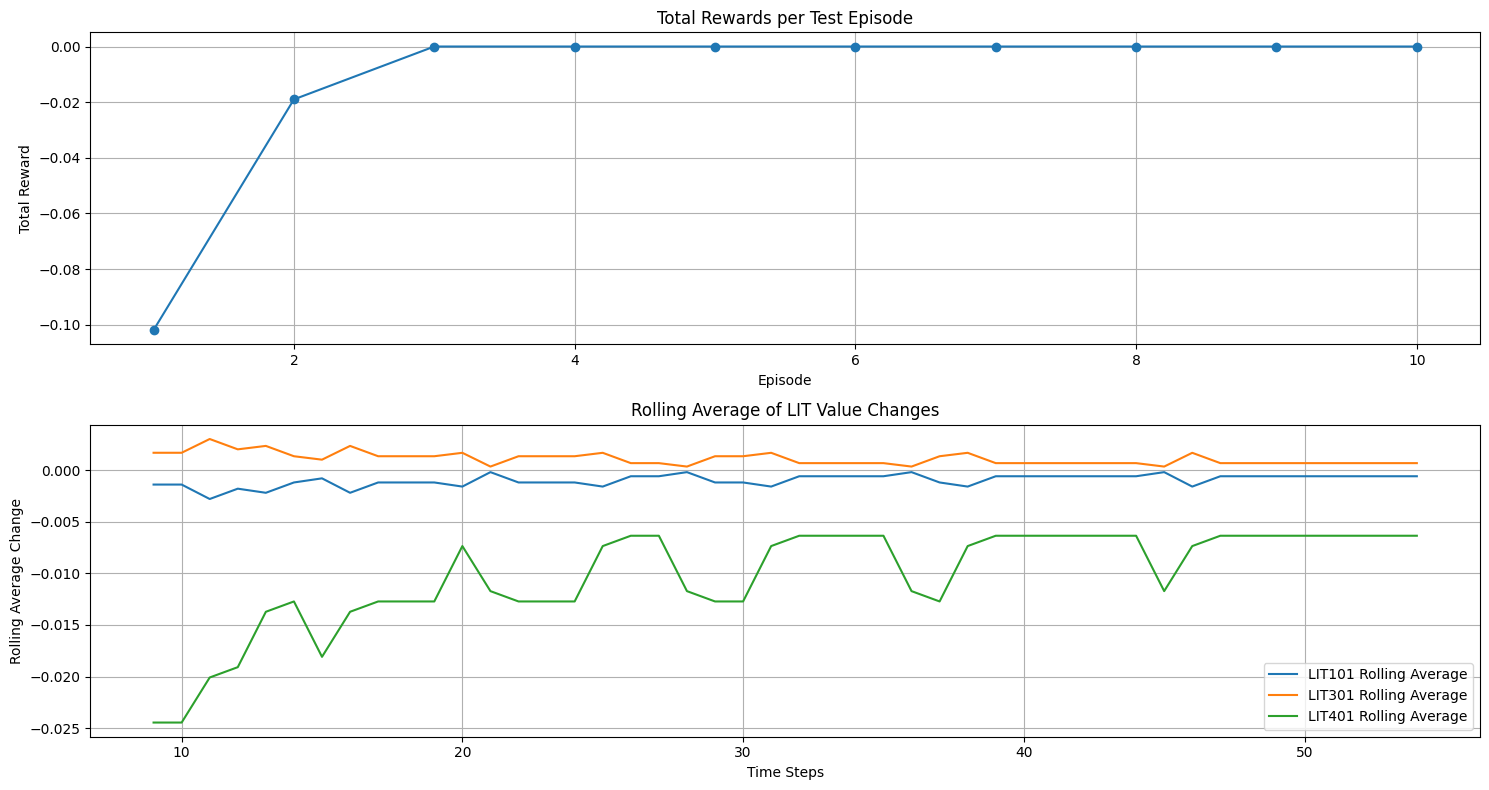

In [100]:
# Assuming `lit101_values`, `episode_rewards`, `losses`, and `trained_model` are obtained from training:
#lit101_values, episode_rewards, losses, trained_model = run_dqn_trial(SwatEnv, data_array, #window_size=19, episodes=200)

# Test the trained model's performance
test_model_performance(SwatEnv, trained_model, data_array, window_size=19, test_episodes=10, max_steps=200)


In [30]:
def test_model_performance(environment, model, data_array, window_size=19, test_episodes=10, max_steps=100):
    """
    Test the performance of the trained DQN model.
    
    :param environment: SWaTEnv environment.
    :param model: Trained DQN model.
    :param data_array: Input data array for the environment.
    :param window_size: Size of the data window for state history.
    :param test_episodes: Number of test episodes to evaluate.
    :param max_steps: Maximum steps per episode.
    :return: None. The function prints and plots the performance results.
    """
    
    # Initialize the environment for testing
    test_env = environment(data_array, window_size)
    
    # Metrics to track
    total_rewards = []
    lit_values_changes = {'LIT101': [], 'LIT301': [], 'LIT401': []}  # Track LIT values changes over episodes

    for episode in range(1, test_episodes + 1):
        # Reset the environment to get the initial state
        state = test_env.reset()
        state = np.reshape(state, [1, test_env.observation_space.shape[1]])  # Reshape for the neural network

        episode_reward = 0
        lit101_values = []  # Track LIT101 values for the episode
        lit301_values = []  # Track LIT301 values for the episode
        lit401_values = []  # Track LIT401 values for the episode

        for step in range(max_steps):
            # Select action based on the highest Q-value (no exploration)
            q_values = model.predict(state)
            action_index = np.argmax(q_values)

            # Convert action index to binary array of length 6
            action = np.array(list(np.binary_repr(action_index, width=6))).astype(int)

            # Take the action and observe the next state and reward
            next_state, reward, value_change, done = test_env.step(action)
            next_state = np.reshape(next_state, [1, test_env.observation_space.shape[1]])  # Reshape for the network

            # Accumulate the reward
            episode_reward += reward
            lit101_values.extend(value_change['LIT101'])  # Track LIT101 value changes
            lit301_values.extend(value_change['LIT301'])  # Track LIT301 value changes
            lit401_values.extend(value_change['LIT401'])  # Track LIT401 value changes

            # Update the current state
            state = next_state

            if done:
                break

        # Track metrics for this episode
        total_rewards.append(episode_reward)
        lit_values_changes['LIT101'].append(lit101_values)
        lit_values_changes['LIT301'].append(lit301_values)
        lit_values_changes['LIT401'].append(lit401_values)

        print(f"Test Episode: {episode}/{test_episodes}, Total Reward: {episode_reward:.4f}")

    # Print average performance
    avg_reward = np.mean(total_rewards)
    print(f"Average Total Reward over {test_episodes} episodes: {avg_reward:.4f}")

    # Plot performance results
    plot_test_performance(total_rewards, lit_values_changes)


def plot_test_performance(rewards, lit_values_changes, rolling_window=10):
    """
    Plot the rewards and rolling average of LIT values over test episodes.

    :param rewards: List of rewards per episode.
    :param lit_values_changes: Dictionary of LIT value changes over episodes.
    :param rolling_window: Window size for calculating rolling average.
    :return: None.
    """
    # Create subplots for total rewards and rolling average for LIT values
    plt.figure(figsize=(15, 8))

    # Plot total rewards for each episode
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(rewards) + 1), rewards, marker='o')
    plt.title('Total Rewards per Test Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)

    # Create a subplot for rolling average of LIT101, LIT301, and LIT401 changes
    plt.subplot(2, 1, 2)
    for lit_component, value_changes in lit_values_changes.items():
        # Flatten the list of lists for each component
        flattened_values = [item for sublist in value_changes for item in sublist]
        
        # Calculate rolling average
        if len(flattened_values) >= rolling_window:
            rolling_avg = pd.Series(flattened_values).rolling(window=rolling_window).mean()
            plt.plot(rolling_avg, label=f'{lit_component} Rolling Average')

    plt.title('Rolling Average of LIT Value Changes')
    plt.xlabel('Time Steps')
    plt.ylabel('Rolling Average Change')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 24)          │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 24)          │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 4)           │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,612 (6.30 KB)

 Trainable params: 1,612 (6.30 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_plot_lit301(lstm_model, data_array, window_size=19, num_steps=1200):
    """
    Predict 1200 consecutive steps using the LSTM model and plot LIT301 against original values.
    
    :param lstm_model: The trained LSTM model.
    :param data_array: The original data array used for training.
    :param window_size: The size of the input window for predictions.
    :param num_steps: The number of consecutive steps to predict.
    :return: None. The function generates a plot.
    """
    
    if len(data_array.shape) == 2:
        data_array = data_array[np.newaxis, :, :]  # Adds a new axis to make it 3D
    # Select the initial window of data for prediction
    state_history = data_array[:, :window_size, :]
    
    # Placeholder for predicted LIT301 values
    predicted_lit301 = []
    original_lit301 = []

    # Make sequential predictions for `num_steps` steps
    for step in range(num_steps):
        # Predict the next state using the LSTM model
        next_state = lstm_model.predict(state_history)
        
        # Append the LIT301 value from the predicted state and the original state
        predicted_lit301.append(next_state[0, component_pos['LIT301']])
        original_lit301.append(data_array[0, window_size + step, component_pos['LIT301']])
        
        # Update the state history by appending the new state and removing the oldest state
        state_history = np.concatenate((state_history[:, 1:, :], next_state[:, np.newaxis, :]), axis=1)
        
        # Stop if we reach the end of the available data
        if window_size + step + 1 >= data_array.shape[1]:
            break

    # Convert lists to numpy arrays for easy plotting
    predicted_lit301 = np.array(predicted_lit301)
    original_lit301 = np.array(original_lit301)

    # Plot the predicted LIT301 values against the original values
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(original_lit301)), original_lit301, label='Original LIT301', color='blue')
    plt.plot(range(len(predicted_lit301)), predicted_lit301, label='Predicted LIT301', linestyle='--', color='red')
    plt.title('LIT301: Original vs. Predicted Values over 1200 Steps')
    plt.xlabel('Steps')
    plt.ylabel('LIT301 Value')
    plt.legend()
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

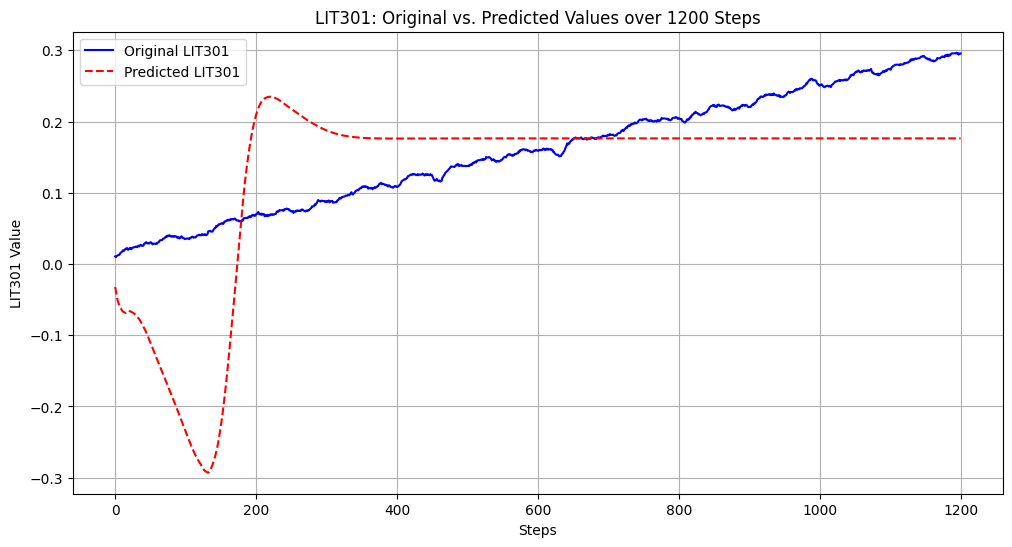

In [53]:
# Assuming `lstm_model` is your trained LSTM model and `data_array` is your input data
predict_and_plot_lit301(swat_lstm, data_array, window_size=19, num_steps=1200)
